In [28]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import seaborn as sns
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
try:
    conn = sqlite3.connect('../data_raw/flats_12December2021.db')
    cursor = conn.cursor()

    cursor.execute(f"SELECT count(*) FROM flats")
    all_ads = cursor.fetchone()[0]
    print(f"Number of ads in the database: {all_ads}")

    sql_query_df = pd.read_sql_query('''
                                        SELECT * 
                                        FROM prices 
                                        LEFT JOIN flats 
                                        ON prices.flat_id = flats.flat_id 
                                        WHERE 
                                            flat_area > 8 and 
                                            location <> "Legionowo, Północne powiaty" and 
                                            price > 20000
                                    ''', conn)

    df = pd.DataFrame(sql_query_df)
    print(df.head(2))
    
    sql_query_prices = pd.read_sql_query('''
                                            SELECT prices.flat_id, date, max(price) as price, location, flat_area
                                            FROM prices 
                                            LEFT JOIN flats 
                                            ON prices.flat_id = flats.flat_id 
                                            GROUP BY prices.flat_id, date
                                        ''', conn)

    df_prices = pd.DataFrame(sql_query_prices)
    print(df_prices.head(2))

except sqlite3.Error as e:
    print("Unable to connect to the database. Try again")

Number of ads in the database: 460824
   price_id  flat_id    price        date  flat_id                      ad_id  \
0         1        0  2290000  2021-01-22        0  1002477418670910470342209   
1         2        1   690000  2021-01-22        1  1003357692990910720650909   

                                     title date_posted date_scraped  \
0  Stara Saska Kępa, wyjątkowy apartament   2018-07-01   2021-01-22   
1             Tarchomin - 104m2 - 5 pokoi   2018-10-26   2021-01-22   

                   location      seller property_type  num_rooms  \
0  Praga Południe, Warszawa     Agencja    Mieszkanie          6   
1       Białołęka, Warszawa  Właściciel    Mieszkanie          5   

   num_bathrooms  flat_area   text  \
0              3        176  Garaż   
1              2        104  Garaż   

                                         description  \
0  'Nowa oferta - doskonały apartament !!!\r\n\r\...   
1  Mieszkanie 5-pokojowe o pow. 104 m2 (118 m2 li...   

               

In [30]:
c_price_change = Counter(df_prices['flat_id'])
price_changes = sum([1 for c,v in c_price_change.items() if v > 1])
print(f"Number of times price of a flat changed: {price_changes}")

Number of times price of a flat changed: 4400


In [31]:
def show_flat_price_history(df, id):
    df_pr_chg = df[df['flat_id'] == id][['date','price','location','flat_area']]

    print(f"Price changes in 2021: {len(df_pr_chg)}")
    print(df_pr_chg[['date','price']])

    tlt = f"{df_pr_chg['location'].iloc[0]} ({df_pr_chg['flat_area'].iloc[0]} m2)"

    plt.figure(figsize=(20, 4))
    plt.plot(df_pr_chg['date'], df_pr_chg['price'])
    plt.title(tlt)
    plt.show()

[16856, 85601, 23943]
Price changes in 2021: 9
             date   price
17308  2021-01-29  549000
17309  2021-02-04  540000
17310  2021-02-05  540001
17311  2021-02-06  540000
17312  2021-02-11  540001
17313  2021-02-12  540000
17314  2021-02-14  540001
17315  2021-02-20  520001
17316  2021-02-22  520001


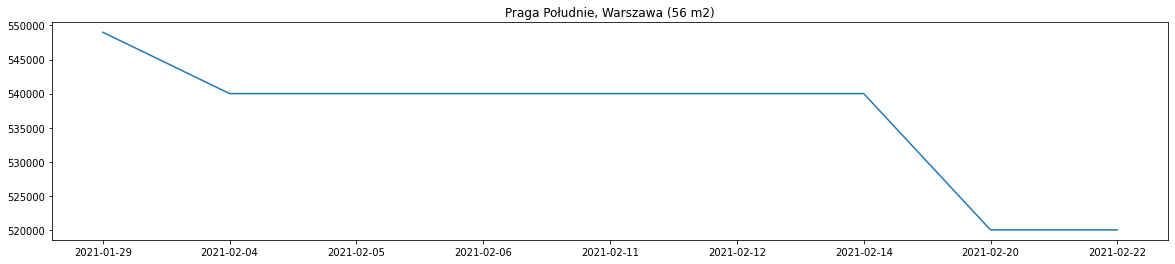

Price changes in 2021: 9
             date   price
87379  2021-03-03  649500
87380  2021-03-04  585000
87381  2021-03-15  565000
87382  2021-03-19  559000
87383  2021-03-20  549000
87384  2021-03-22  545000
87385  2021-03-28  535000
87386  2021-04-02  530000
87387  2021-04-09  525000


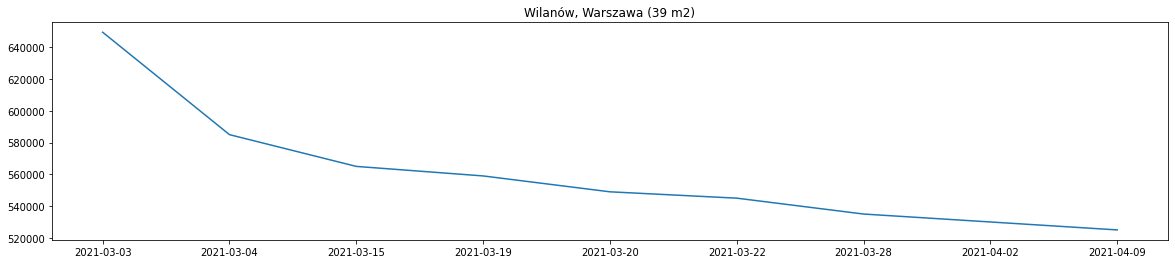

Price changes in 2021: 8
             date   price
24538  2021-02-03  449000
24539  2021-02-04  441000
24540  2021-02-05  440001
24541  2021-02-06  440001
24542  2021-02-07  440000
24543  2021-02-11  435000
24544  2021-02-12  435001
24545  2021-03-07  435000


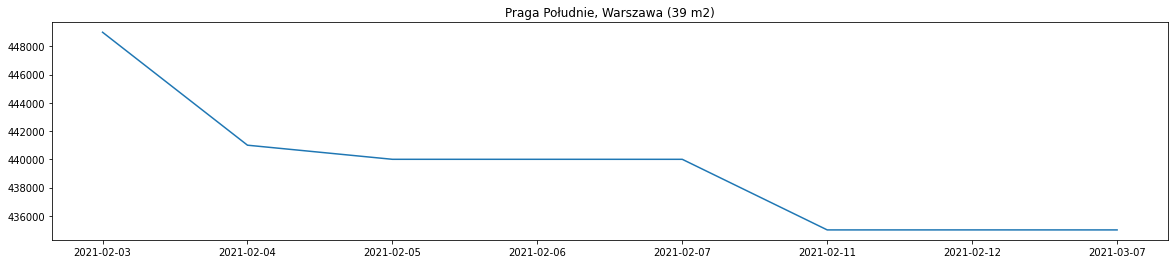

In [32]:
c = Counter(df_prices['flat_id'])
c_ids = [x[0] for x in c.most_common(3)]

print(c_ids)

for id in c_ids:
    show_flat_price_history(df_prices, id)

In [33]:
locations = {
 'Bemowo, Warszawa':'bemowo',
 'Białołęka, Warszawa':'bialoleka',
 'Bielany, Warszawa':'bielany',
 'Mokotów, Warszawa':'mokotow',
 'Ochota, Warszawa':'ochota',
 'Praga Południe, Warszawa':'praga_pld',
 'Praga Północ, Warszawa':'praga_pln',
 'Rembertów, Warszawa':'rembertow',
 'Targówek, Warszawa':'targowek',
 'Ursus, Warszawa':'usrus',
 'Ursynów, Warszawa':'ursynow',
 'Wawer, Warszawa':'wawer',
 'Wesoła, Warszawa':'wesola',
 'Wilanów, Warszawa':'wilanow',
 'Wola, Warszawa':'wola',
 'Włochy, Warszawa':'wlochy',
 'Śródmieście, Warszawa':'srodmiescie',
 'Żoliborz, Warszawa':'zoliboz'
 }

parking = {
    'Brak':'none', 
    'Garaż':'garage', 
    'Kryty':'roofed', 
    'Ulica':'street'
    }

In [34]:
df['district'] = df['location'].apply(lambda x: locations[x])
df['private_owner'] = df['seller'].apply(lambda x: 1 if x=='Właściciel' else 0)
df['parking'] = df['text'].apply(lambda x: parking[x])
df['price_per_m'] = (df['price']//df['flat_area']).apply(lambda x: int(x))

## Data cleaning

- flats with 0 rooms -> data error
- outliers per district
- choose only the necessary features

#### -> Remove the whole row if number of rooms is 0

In [48]:
zero_rooms = df[df['num_rooms'] == 0]
df.drop(df[df['num_rooms'] == 0].index, inplace=True)

assert len(df[df['num_rooms'] == 0]) == 0

In [36]:
top_mok = df.loc[df['district'] == 'mokotow']

top_mok.sort_values(by=['price'], ascending=False)[:10]

,price_id,flat_id,price,date,flat_id,ad_id,title,date_posted,date_scraped,location,...,num_bathrooms,flat_area,text,description,photos_links,page_address,district,private_owner,parking,price_per_m
171923,172185,169574,732868225,2021-04-08,169574,1009160968200912786672909,3 POKOJOWE | CICHE ROZKŁADOWE | SIELCE,2021-04-08,2021-04-08,"Mokotów, Warszawa",...,1,57,Ulica,"Ciche, rozkładowe mieszkanie 3-pokojowe na kam...",['https://i.ebayimg.com/00/s/NTMzWDgwMA==/z/Ih...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,1,street,12857337
413099,413791,409801,36000000,2021-11-18,409801,10010167499541010478276309,Cybulskiego Villa Monaco w parku luksusowe 4...,2021-11-18,2021-11-18,"Mokotów, Warszawa",...,3,144,Garaż,"AGENCJA KOWALEWSKI OFERUJEElegancki, ekskluzyw...",['https://i.ebayimg.com/00/s/NTMzWDgwMA==/z/Yb...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,garage,250000
250414,250825,247769,36000000,2021-05-17,247769,1009352432140911080447209,Villa Monaco Cybulskiego w parku luksusowe 4 ...,2021-05-17,2021-05-17,"Mokotów, Warszawa",...,3,144,Garaż,AGENCJA KOWALEWSKI OFERUJEVILLA MONACO- ul. Cy...,['https://i.ebayimg.com/00/s/NTMzWDgwMA==/z/PQ...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,garage,250000
413104,413796,409806,36000000,2021-11-18,409806,10010167499541010478276309,Cybulskiego Villa Monaco w parku luksusowe 4...,2021-11-18,2021-11-18,"Mokotów, Warszawa",...,3,144,Garaż,"AGENCJA KOWALEWSKI OFERUJEElegancki, ekskluzyw...",['https://i.ebayimg.com/00/s/NTMzWDgwMA==/z/Yb...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,garage,250000
242583,242964,239879,25500000,2021-05-08,239879,1009313191020911080447209,Madalińskiego Mokotów ekskluzywny apartament 2...,2021-05-08,2021-05-08,"Mokotów, Warszawa",...,3,178,Garaż,"AGENCJA KOWALEWSKI OFERUJEElegancki, ekskluzyw...",['https://i.ebayimg.com/00/s/NjAwWDgwMA==/z/RE...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,garage,143258
308920,309446,306749,25490000,2021-09-05,306749,1009851921030911080447209,Madalińskiego Mokotów elegancki apartament 5 p...,2021-09-05,2021-09-05,"Mokotów, Warszawa",...,3,178,Garaż,"AGENCJA KOWALEWSKI OFERUJEElegancki, ekskluzyw...",['https://i.ebayimg.com/00/s/NjAwWDgwMA==/z/de...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,garage,143202
422461,423176,419016,25490000,2021-11-22,419016,10010183669061010478276309,Madalińskiego Mokotów elegancki apartament 5 p...,2021-11-22,2021-11-22,"Mokotów, Warszawa",...,3,178,Garaż,"AGENCJA KOWALEWSKI OFERUJEElegancki, ekskluzyw...",['https://i.ebayimg.com/00/s/NjAwWDgwMA==/z/UQ...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,garage,143202
369272,369907,366557,16000000,2021-11-02,366557,10010099531721011379840509,4pok* dwustronne* balkon 18m2* gotowe* Mokotów,2021-11-02,2021-11-02,"Mokotów, Warszawa",...,1,94,Garaż,"Nowe, dwustronne, 4 pokojowe mieszkanie z 18 m...",['https://i.ebayimg.com/00/s/NjI2WDk0MA==/z/hK...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,garage,170212
306647,307170,304440,14900000,2021-09-01,304440,1009836473980912596317609,"SPRZEDAM BEZPOŚREDNIO 3 pokoje Mokotów, Belwed...",2021-09-01,2021-09-01,"Mokotów, Warszawa",...,1,76,Kryty,Bezpośrednio od właściciela.Apartament wykończ...,['https://i.ebayimg.com/00/s/NTMzWDgwMA==/z/h2...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,1,roofed,196052
337813,338400,335616,10161310,2021-10-12,335616,10010012275101011559470109,Mieszkanie Warszawa Mokotów 350.39m2 (nr: SOL-...,2021-10-12,2021-10-12,"Mokotów, Warszawa",...,3,351,Brak,"Wyjątkowy penthouse w kameralnej inwestycji, w...",['https://i.ebayimg.com/00/s/NzY4WDEwMjQ=/z/cl...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,none,28949


In [37]:
len(df.loc[df['price'] > 8_000_000])

281

### Remove outliers in each district

In [38]:
districts = df['district'].unique()
no_outl_df = pd.DataFrame()

for district in districts:
    df_d = df.loc[df['district'] == district]
    no_outl_price = df_d[(np.abs(stats.zscore(df_d['price'])) < 3)]
    no_outl_area = no_outl_price[(np.abs(stats.zscore(no_outl_price['flat_area'])) < 3)]

    no_outl_df = no_outl_df.append(no_outl_area)

no_outl_df = no_outl_df.loc[no_outl_df['flat_area'] < 300]


## Visualise prices in each district

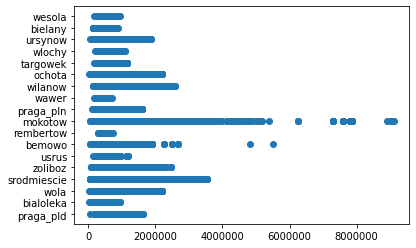

In [39]:
plt.scatter(no_outl_df['price'], no_outl_df['district'])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

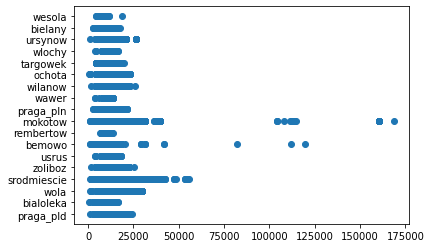

In [40]:
plt.scatter(no_outl_df['price_per_m'], no_outl_df['district'])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

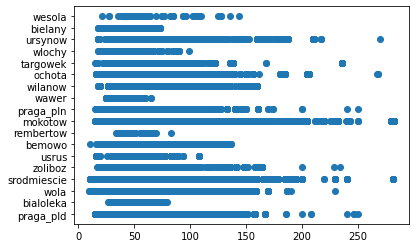

In [41]:
plt.scatter(no_outl_df['flat_area'], no_outl_df['district'])
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
plt.show()

### Check the first rows with outliers

In [49]:
outl_df_m = df[(np.abs(stats.zscore(df['price_per_m'])) > 3)]
outl_df_m.head(3)

,price_id,flat_id,price,date,flat_id,ad_id,title,date_posted,date_scraped,location,...,num_bathrooms,flat_area,text,description,photos_links,page_address,district,private_owner,parking,price_per_m
29575,29628,29290,4790000,2021-02-06,29290,1008840684890910912811309,2 minuty pieszo do Metra | MOKOTÓW,2021-02-06,2021-02-06,"Mokotów, Warszawa",...,1,46,Brak,Na sprzedaż 2 pokojowe mieszkanie o powierzchn...,['https://i.ebayimg.com/00/s/NjAwWDQ1MA==/z/U7...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,none,104130
30182,30235,29897,4790000,2021-02-07,29897,1008842441830910912811309,2 minuty pieszo do Metra | MOKOTÓW,2021-02-07,2021-02-07,"Mokotów, Warszawa",...,1,46,Brak,Na sprzedaż 2 pokojowe mieszkanie o powierzchn...,['https://i.ebayimg.com/00/s/NjAwWDQ1MA==/z/tn...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,none,104130
31067,31124,30777,9008000,2021-02-07,30777,1008845365090911379840509,"Mokotów, 4 pok., 79, 41m2, 2 balkony",2021-02-07,2021-02-07,"Mokotów, Warszawa",...,1,80,Brak,Mieszkanie 4 pokojowe + 2 balkony\nKameralna p...,['https://i.ebayimg.com/00/s/NjgyWDEwMjQ=/z/7H...,https://www.gumtree.pl/a-mieszkania-i-domy-spr...,mokotow,0,none,112600


## How size of the flat is affecting the price

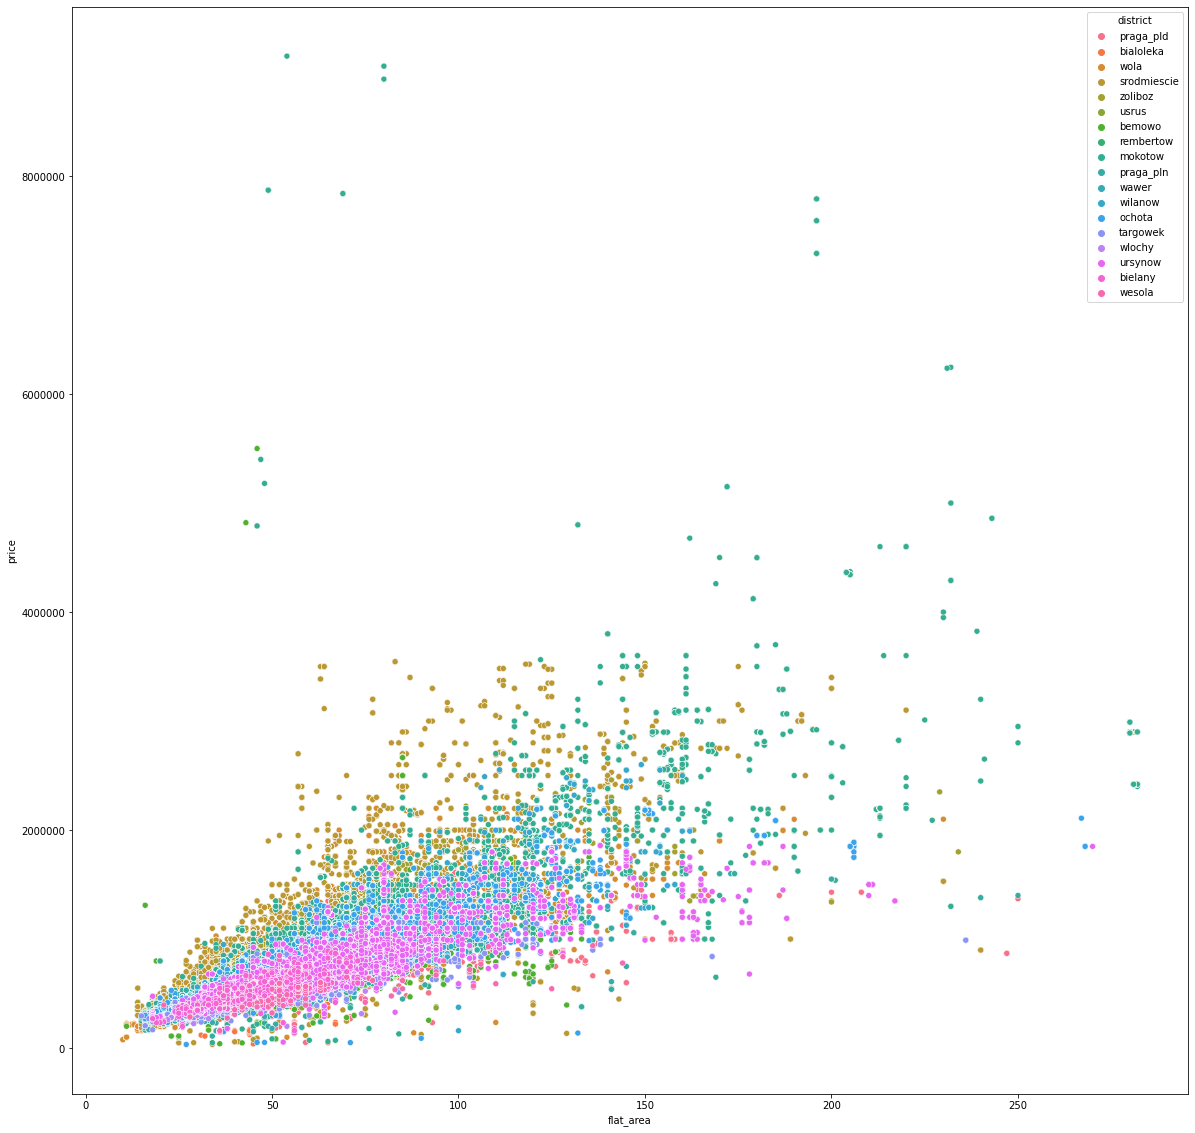

In [50]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.scatterplot(x='flat_area', y='price', data=no_outl_df, hue='district', ax=ax)
ax = plt.gca()
plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [44]:
data = no_outl_df[['price', 'date', 'district','private_owner','num_rooms','num_bathrooms','flat_area','parking']]
data.head(3)

,price,date,district,private_owner,num_rooms,num_bathrooms,flat_area,parking
4,390000,2021-01-18,praga_pld,1,1,1,26,garage
11,500000,2021-01-27,praga_pld,1,2,1,43,none
12,590000,2021-01-29,praga_pld,1,2,1,50,none


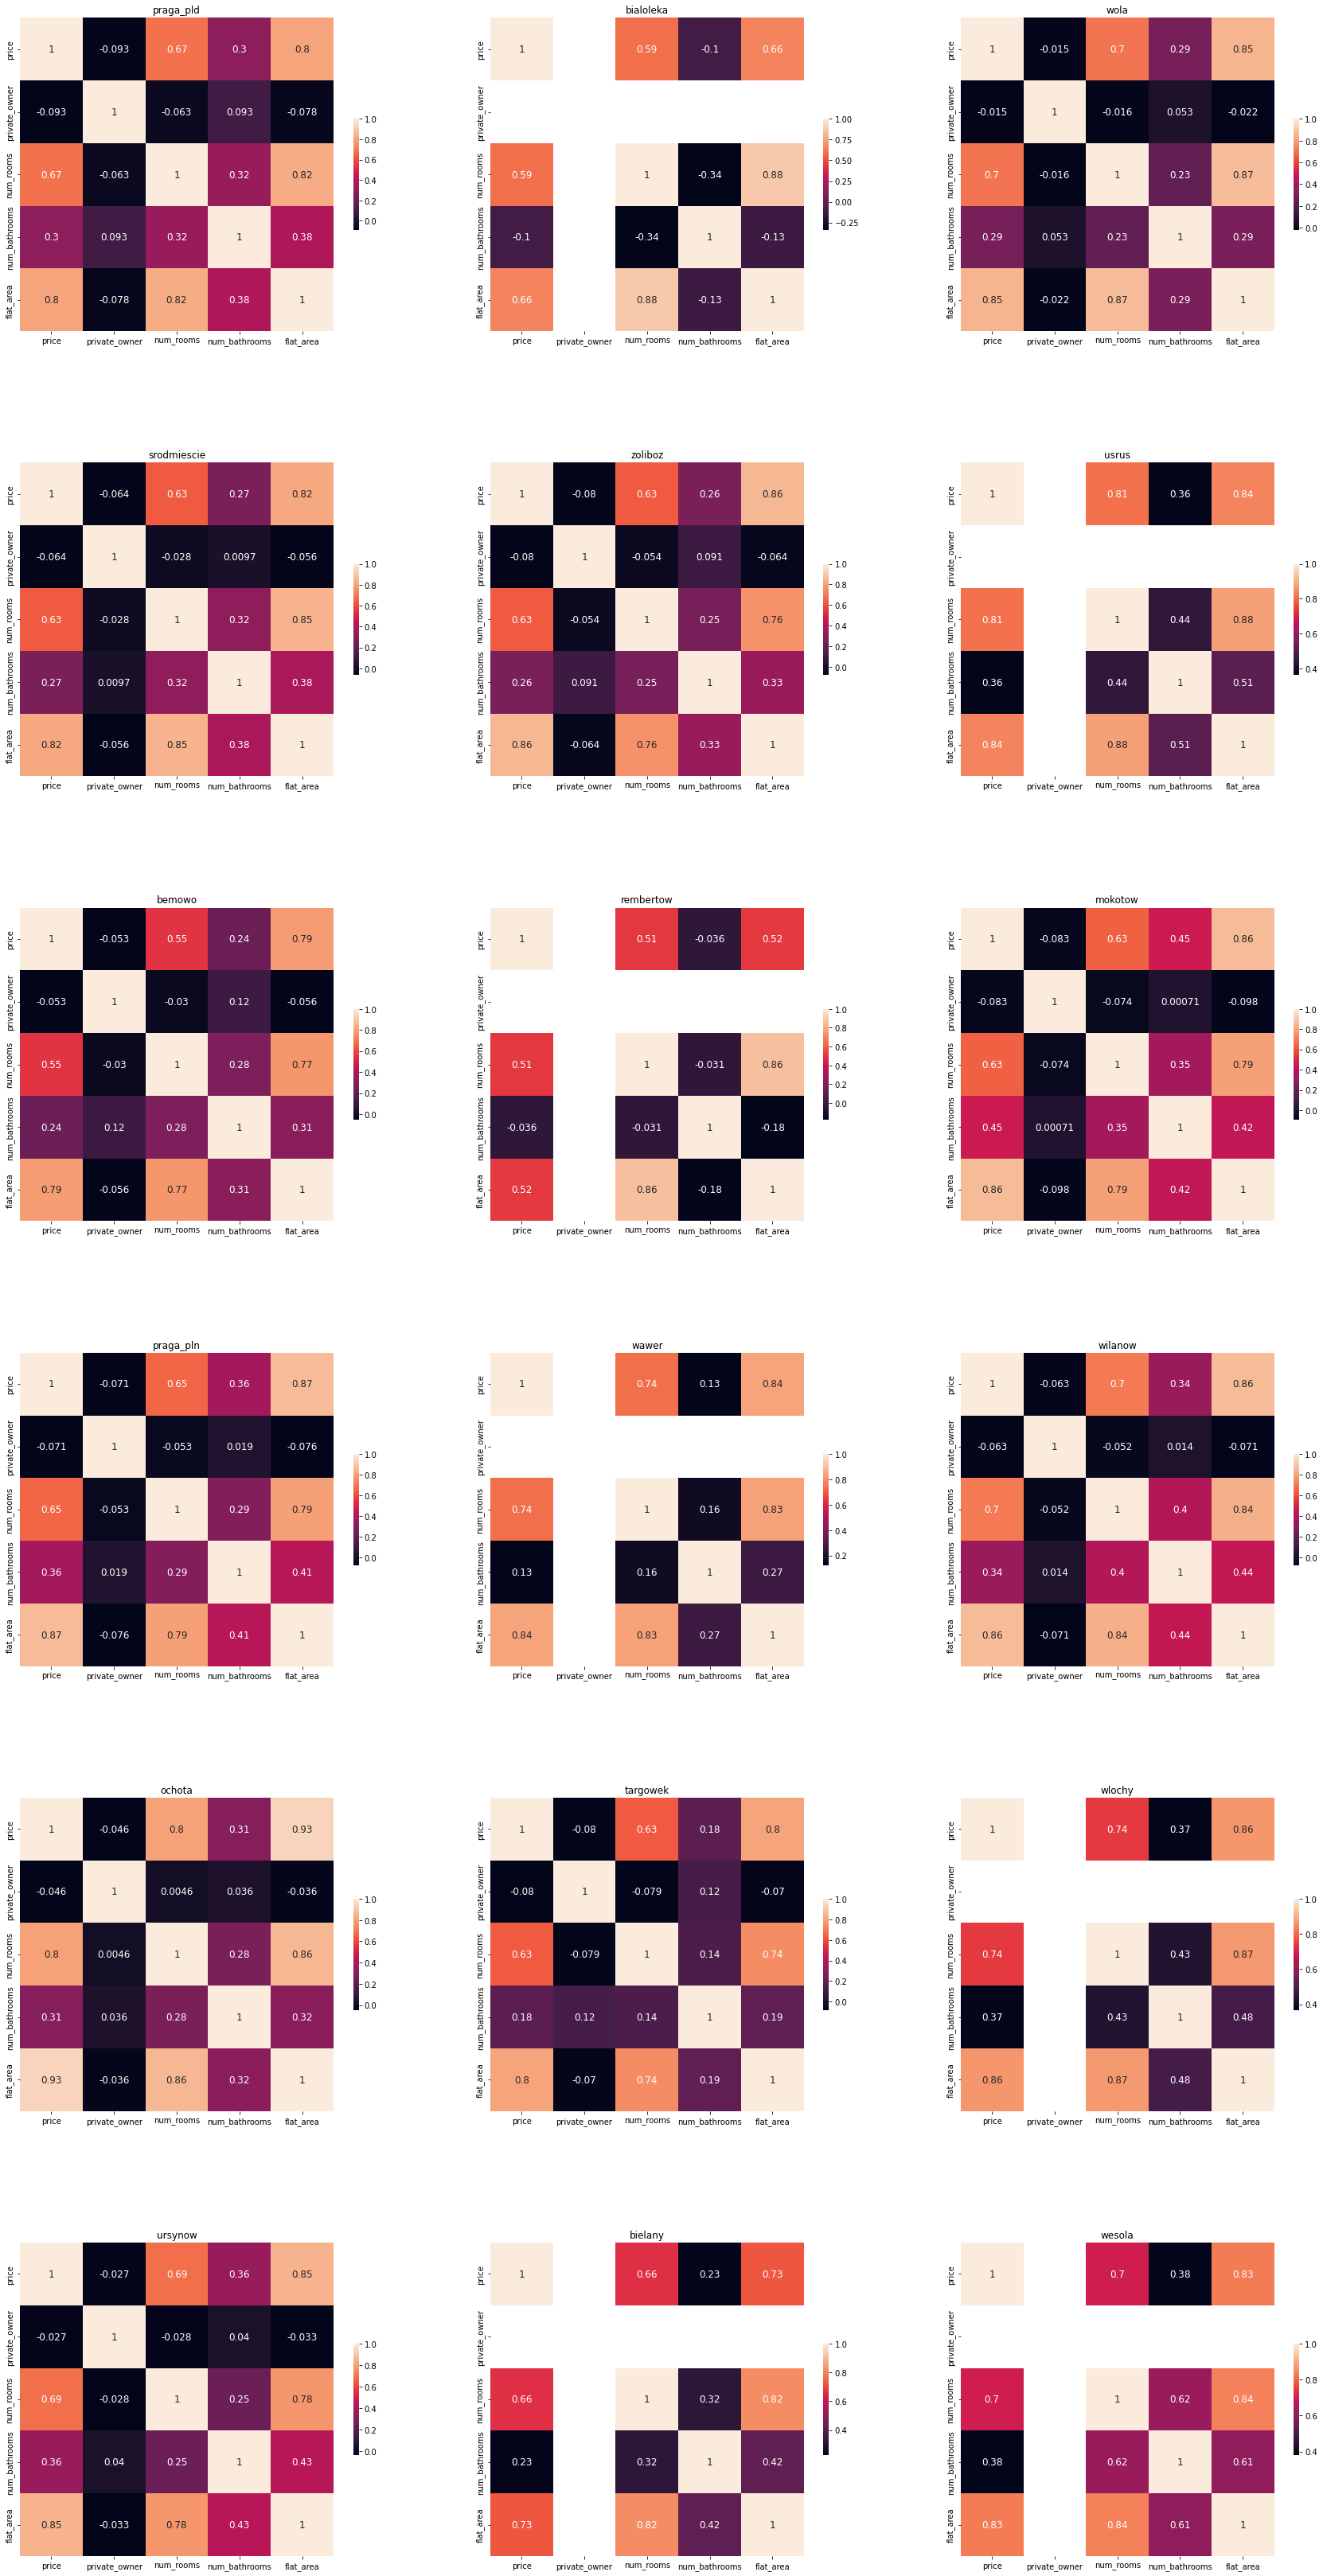

In [45]:
districts = data['district'].unique()

fig = plt.figure(figsize = (30, 60))
for i, district in enumerate(districts):
    subset = data.loc[data['district'] == district]

    ax = fig.add_subplot(6, 3, i+1) # row, column, position
    ax.set_title(district)
    sns.heatmap(data=subset.corr(), ax=ax, square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

plt.show()


/Users/malgorzatabslcerzak/Documents/projects/warsaw-real-estate-analysis/.venv/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


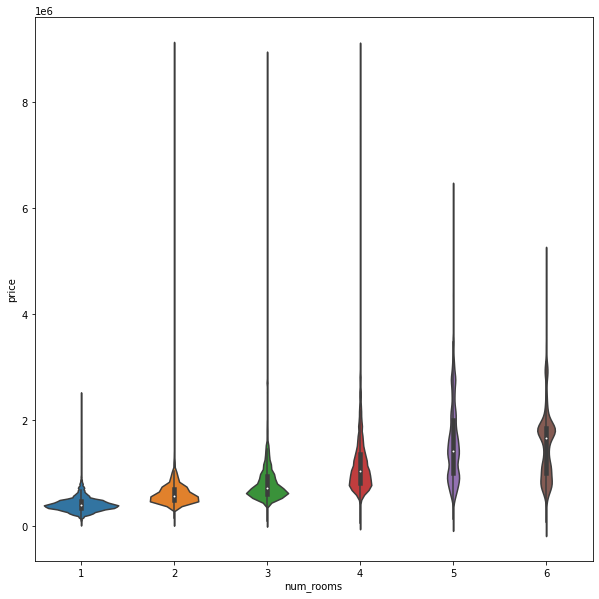

In [46]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.violinplot('num_rooms', 'price', data=no_outl_df, ax=ax)
ax = plt.gca()
plt.show()

In [47]:
no_outl_df.to_pickle("../data_preprocessed/data.pkl", protocol=5)